In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score



import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

We start by loading the previously created dataframe with the answers to the questions we asked gpt. We also read the 20 questions, which are stored in `questions` below.

In [2]:
romance_with_binary = pd.read_csv('./Data/Preprocessed/romances.with.binary.tsv', delimiter='\t')
romance_with_binary.head(3)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000


In [3]:
f = open('Data/trope_questions.txt', 'r')

line = f.readline()
questions = []

while len(line)!=0:
    questions.append(line.strip())
    line = f.readline()
    
questions = questions[1:-1]

# A) Preprocessing

In [4]:
gpt_answers = romance_with_binary[['movie_id', 'binary_answers']].copy()
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))
#gpt_answers.head(3)

In [5]:
bits = {'0', '1', '2'}
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: ''.join(c for c in b if c in bits))
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))

In [6]:
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: b if len(b)==20 else '2'*20)
gpt_answers.drop(columns=['response_length'], inplace=True)
gpt_answers.head(5)

,movie_id,binary_answers
0,6631279,01001000000001111000
1,21926710,00000001000001000100
2,26067101,01000000001000001000
3,12053509,01000000000111011000
4,7028314,00010011010001001000


In [7]:
for q_nb, question in enumerate(questions):
    gpt_answers[f'q_{q_nb}'] = gpt_answers['binary_answers'].apply(lambda b: int(b[q_nb]))
    
gpt_answers.head(5)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


And let's plot how many answers to the questions were negative, positive and unknown for each question.

In [8]:
def plot(df):
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        sbplt = ax[i%4, math.floor(i/4)]
        sbplt.hist(df[f'q_{i}'])
        sbplt.set_title(f'Question {i}')

    fig.tight_layout()
    fig.suptitle('Histogram of answers (0, 1, and 2) for each question', y=1.05, fontsize=20)
    plt.show()

#plot(gpt_answers)

In [9]:
def plot_pie_charts(df):
    fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (12,10))

    for r in range(4):
        for c in range(5):
            ax[r,c].pie(df[f'q_{r*5+c}'].value_counts(),
                        labels = df[f'q_{r*5+c}'].dropna().unique(),
                        autopct=lambda p: '{:.1f}%'.format(p),
                        startangle=90, shadow=False)
            ax[r,c].set_title(f'Question {r*5+c}')
    
    fig.suptitle('Pie charts of percentage of answers (0, 1, and 2) for each question', y=1.01, fontsize=15)
    fig.tight_layout()
            
#plot_pie_charts(gpt_answers)

In [10]:
relevant_answers = gpt_answers[gpt_answers['binary_answers']!='2'*20].copy()

print(f"There are {relevant_answers['binary_answers'].count()-relevant_answers['binary_answers'].str.contains('1').sum()} movies that do not even contain a 1")

There are 610 movies that do not even contain a 1


As seen above, there are around 600 movies that have no positive answer at all. Some examples of these movies are Spirit, Harry Potter movies... Note that these movies should not be considered romance movies in the first place ! It is thus good that GPT outputs a `00000000000000000000` when analyzing them. 

In fact, this gives us a rationale to trim even more the dataset : if a movie does not contain any of the 20 clichés, is it in fact a romance movie ? It seems that most of the all `0`'s strings are in fact from movies that are not romance centered at all. We thus choose an (arbitrary) threshold to consider a movie `Romance` : it should contain at least 3 positive answers. 

4380


(array([211., 290., 436., 626., 779., 757., 737., 525., 375., 215., 100.,
         53.,  27.,  11.,   4.,   4.,   1.,   2.,   0.,   1.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

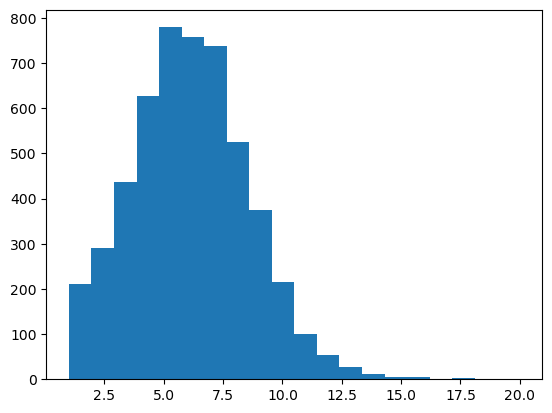

In [60]:
# First remove any string consisting of only 2s
#df = gpt_answers[gpt_answers['binary_answers']!='2'*20].copy()

# Define the questions list, ie all columns
questions_list = ['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 'q_19']

# We keep only the strings with at least a 1. 
# This way we remove the all 0s strings, the all 2s strings, and the mixed strings.
df = gpt_answers[gpt_answers['binary_answers'].str.contains('1')].copy()

filenames = df['movie_id']
filenames = filenames.apply(lambda x : str(x) + '.xml.gz').values

# 4380 different binary answers
print(len(gpt_answers['binary_answers'].unique()))

# Remove all the entries that (somehow) have more than 20 positive answers, and then plot the histogram of #1s.
df['total'] = df[questions_list].sum(axis = 1)
df = df[21 > df['total']]
plt.hist(df['total'], bins = 20)

In [55]:
print(len(filenames))

5159


In [62]:
from pathlib import Path

root = Path(r"C:\Users\robin\Documents\EPFL\ACL2013_Personas\preprocess\corenlp_plot_summaries")
filenames = filenames

for path in root.iterdir():
    if path.name not in filenames:
        path.unlink()

We should expect, after keeping only movies with 3 positive answers or more, to have around 4500 movies.

In [12]:
# Keep only entries with at least 3 positive answers: this captures the "real" romance movies.
df = df[df['total'] > 0]
display(df)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19,total
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,1,1,1,1,0,0,0,6
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,3
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,3
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,6
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,1,0,0,1,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5877,4037444,00010100010001000000,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,4
5878,1191380,00001000110110100010,0,0,0,0,1,0,0,0,...,1,1,0,1,0,0,0,1,0,7
5879,54540,10000000001000010010,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,4
5880,1673588,00000001010000000000,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2


Now that we refined our dataset, we only have $4653$ movies now. Let's plot each question's statistics !

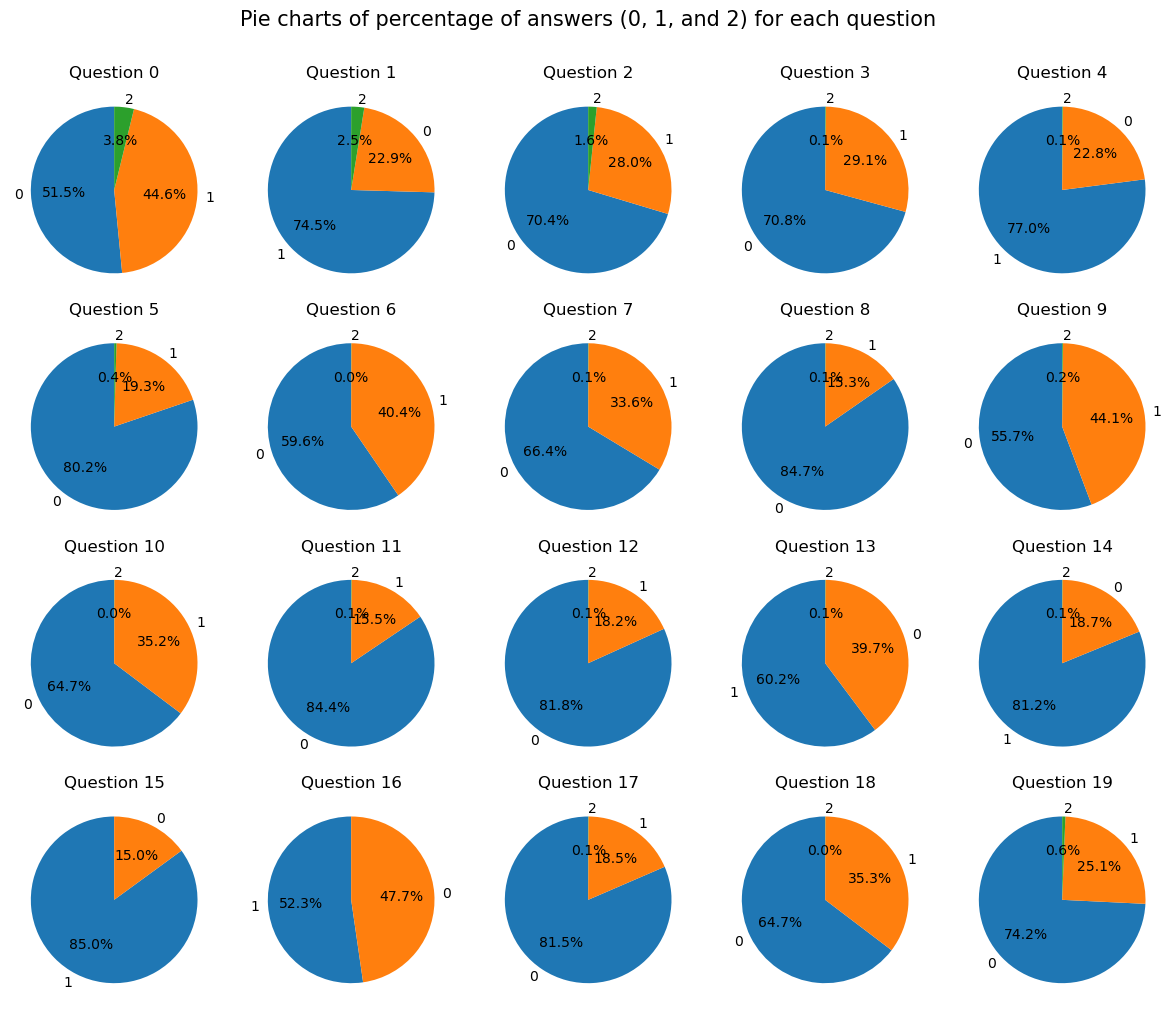

In [13]:
plot_pie_charts(df)

In [14]:
col_to_keep = ['movie_id', 'movie_release', 'binary_answers']
for i in range(len(questions)):
    col_to_keep.append(f'q_{i}')
    
# Perform a right merge : we only care about the relevant answers
gpt_year = romance_with_binary.merge(df, on=['movie_id', 'binary_answers'], how='right')[col_to_keep]
gpt_year.replace(2, np.NaN, inplace=True)

At this point, we can wonder : is there a clear trend as to how clichés evolve over time ? As an example, could we say that modern movies contain less weddings stopped at the altar ?

In [15]:
def plot_answer_by_year(df): 
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        ax[i%4, math.floor(i/4)].set_title(f'Question {i}')
        sns.lineplot(df, x='movie_release', y=f'q_{i}', ax=ax[i%4, math.floor(i/4)])

    fig.tight_layout()
    plt.show()
    
#plot_answer_by_year(gpt_year)
#plot_answer_by_year(gpt_year[gpt_year['movie_release']>1920])

In [16]:
#plot_answer_by_year(gpt_year[gpt_year['movie_release']>1920])

# B) Analysis of single questions

In [17]:
## When sophie gives tsv : just import it as df

,movie_id,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
4515,31046582,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,97.0,{},{'/m/09c7w0': 'United States of America'},1999.0,"['Comedy', 'Adventure', 'Romance', 'Thriller',...",tt0176948,4.9,501.0,10000000000000000000
5231,4600711,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,NaN,109.0,"{'/m/03115z': 'Mandarin Chinese', '/m/0653m': ...","{'/m/03h64': 'Hong Kong', '/m/0d05w3': 'China'}",2003.0,"['Crime', 'Adventure', 'Romance', 'Thriller', ...",tt0413515,6.2,501.0,10011001000001110000
4087,25751926,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,66.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1935.0,"['Music', 'Comedy', 'Romance']",tt0027188,6.3,503.0,00000111111000001000
5120,16797102,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,69.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1934.0,"['Comedy', 'Romance', 'Black-and-white', 'Crime']",tt0025290,6.3,504.0,00100000000000100000
3543,18083698,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,87.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1964.0,"['Comedy', 'Romance']",tt0161612,4.9,504.0,10100001000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,8980330,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5.213119e+08,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},2008.0,"['Comedy', 'Adventure', 'Romance', 'Family', '...",tt0910970,8.4,1170697.0,00000010000110100000
1218,321496,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,6.542640e+08,143.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},2003.0,"['Adventure', 'Comedy', 'Romance', 'Action', '...",tt0325980,8.1,1180834.0,00000101001001001010
3742,44122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.562966e+08,100.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1999.0,"['Comedy', 'Romance', 'Satire', 'Black Comedy'...",tt0169547,8.3,1190830.0,00000001000000000000
1467,52371,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,2.185372e+09,194.0,"{'/m/02bjrlw': 'Italian Language', '/m/02h40lc...",{'/m/09c7w0': 'United States of America'},1997.0,"['Adventure', 'Romance', 'History', 'Fiction',...",tt0120338,7.9,1252013.0,01111111011000001001


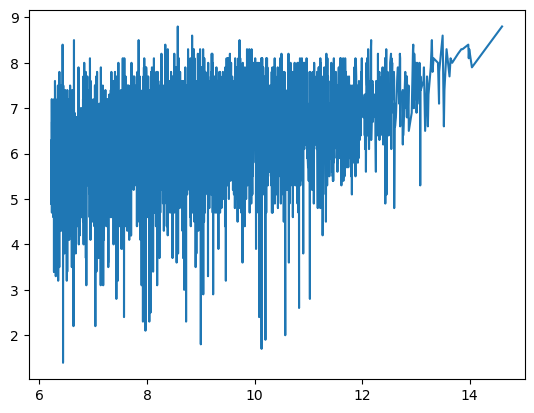

In [18]:
trimmed = df.drop(['binary_answers'], axis = 1)
trimmed = trimmed.replace(2, np.NaN)
#trimmed = trimmed.astype(pd.Int64Dtype())
df = trimmed.merge(romance_with_binary, on = 'movie_id', how = 'left')


# TODO : MAYBE REMOVE THIS !
#df = df[df.nb_votes > 10000]

df = df[(df.nb_votes > 500)]
#print(df.info())
df = df.sort_values(by='nb_votes')
plt.plot(np.log(df.nb_votes), df.rating)

display(df)

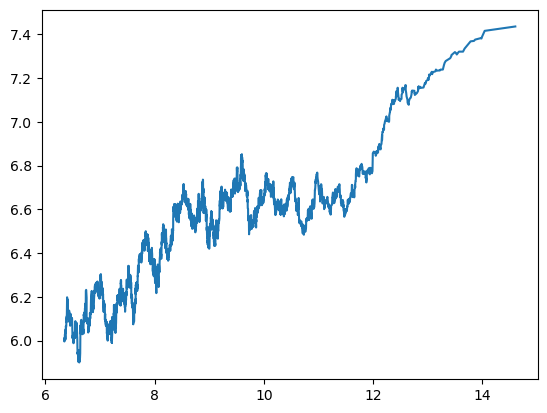

In [19]:
df_mva = df.dropna(subset = ['rating', 'nb_votes'])
df_mva['mva'] = df_mva['rating'].rolling(100).mean()
df_mva.dropna(subset = 'mva')
df_mva = df_mva.sort_values(by='nb_votes')
# moving average with a window size of 100
fig, ax = plt.subplots()

plt.plot(np.log(df_mva.nb_votes), df_mva.mva)


<AxesSubplot:xlabel='movie_release', ylabel='rating'>

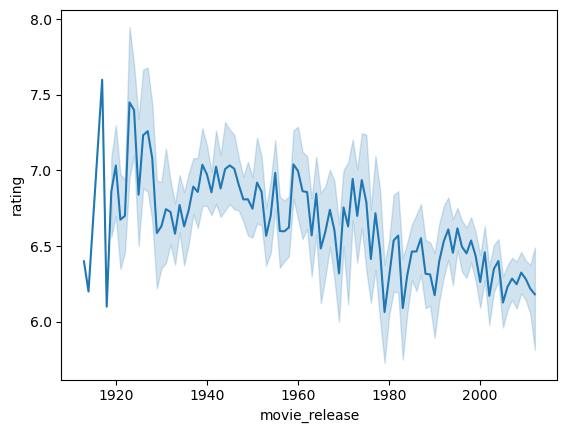

In [20]:
sns.lineplot(data=df, x='movie_release', y='rating')

In [21]:
df["ratings_with_weight"] = [ v + w*1j for v,w in zip(df.rating, df.nb_votes)]
def weighted_mean(x, **kws):
    return np.sum(np.real(x) * np.imag(x)) / np.sum(np.imag(x))

#display(df)


#def weighted_mean(x, **kws):
#    val, weight = map(np.asarray, zip(*x))
#    return (val * weight).sum() / weight.sum()

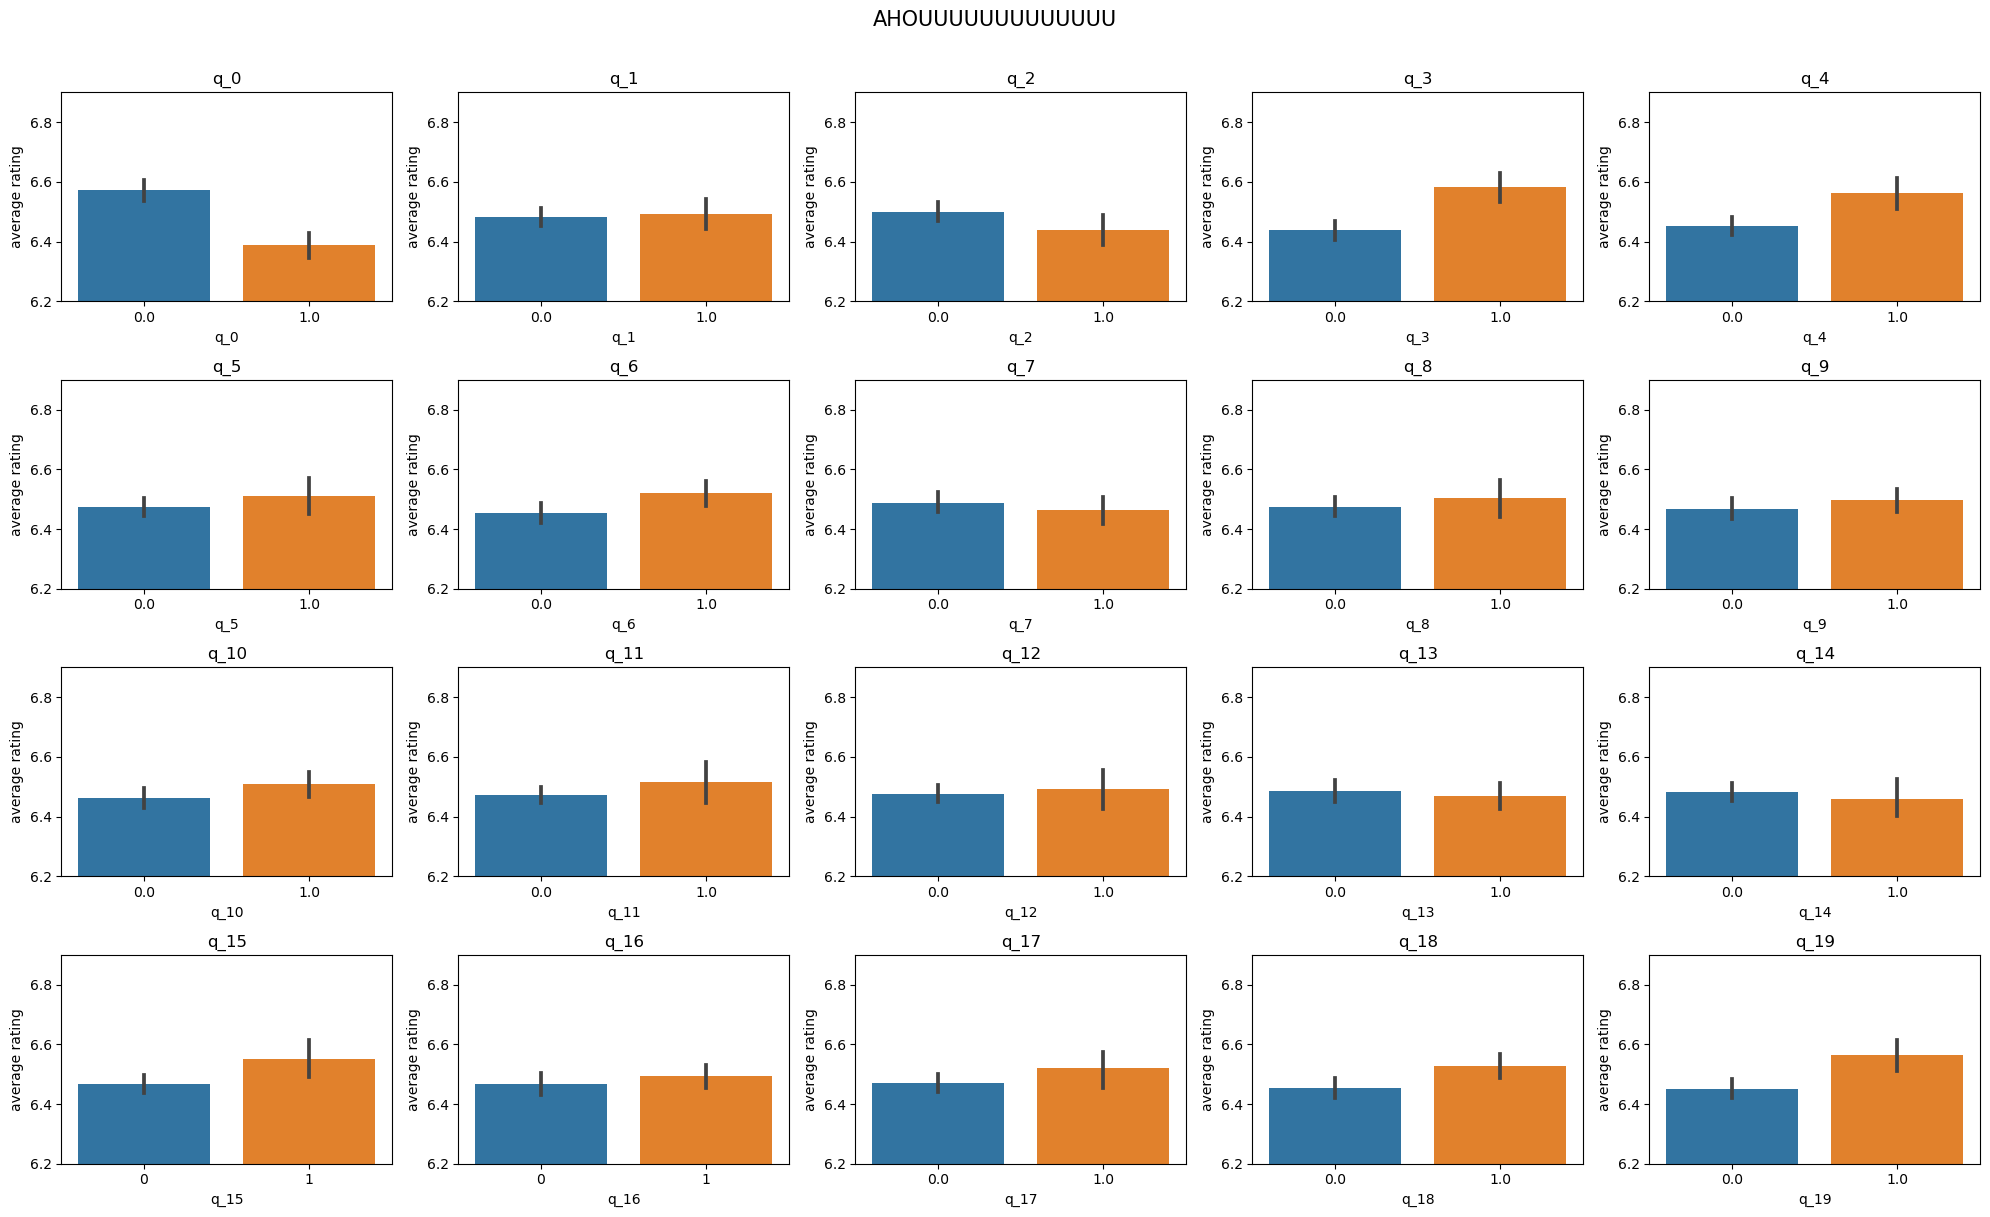

In [22]:
def plot_error_bars(df, nr_rows, nr_cols, weights):
    
    fig, ax = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)
    
    for r in range(nr_rows):
        for c in range(nr_cols):
            
            index = r * 5 + c
            question = 'q_' + str(index)
            
            if weights : 
                sns.barplot(data=df, x= question, y='ratings_with_weight', ax = ax[r][c], estimator = weighted_mean, errorbar=('ci', 95))
                ax[r][c].set_ylim(6.65,7.5)
            else :
                sns.barplot(data=df, x= question, y='rating', ax = ax[r][c])
                ax[r][c].set_ylim(6.2,6.9)

            ax[r][c].set_ylabel('average rating')
            ax[r][c].set_title(question)
            #ax[r,c].set_title(question)
    
    fig.suptitle('AHOUUUUUUUUUUUUU', y=1.01, fontsize=15)
    plt.tight_layout()    
    plt.show()
    
plot_error_bars(df, 4, 5, False)
#plot_error_bars(df, 4, 5, True)

# C) Analysis of ratings

(6.1, 6.6)

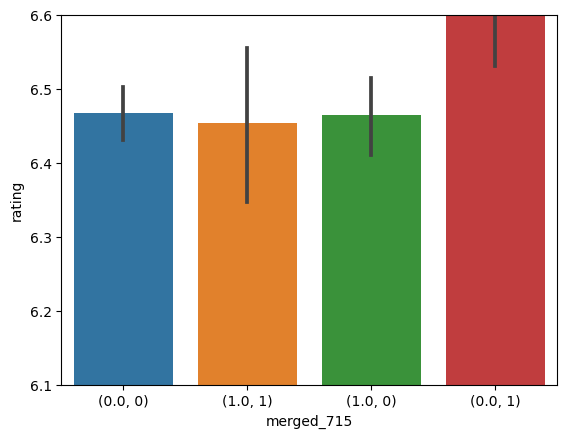

In [23]:
def pair_analysis(id1, id2) : 

    id1 = str(id1)
    id2 = str(id2)
    q1 = 'q_' + id1
    q2 = 'q_' + id2 
    
    df_cleaned = df.dropna(subset=[q1, q2])
    dft = df_cleaned.copy()
    dft['merged_' + id1 + id2] = list(zip(df_cleaned[q1], df_cleaned[q2]))


#df.melt(id_vars = 'rating', value_vars =['q_0', 'q_1'],  
#        var_name ='merged_questions', value_name ='idk') 

    sns.barplot(data = dft, x='merged_'+ id1 + id2,  y='rating')


#sns.barplot(data=df.melt("year", var_name="language", value_name="count"),
#            x="merged_questions",
#            y="count",
#            hue="year")

#for i in range(19) :
#    sns.barplot(new_df, x= 'q_18', y='rating')
pair_analysis(7, 15)
plt.ylim(6.1,6.6)

<AxesSubplot:xlabel='movie_release', ylabel='rating'>

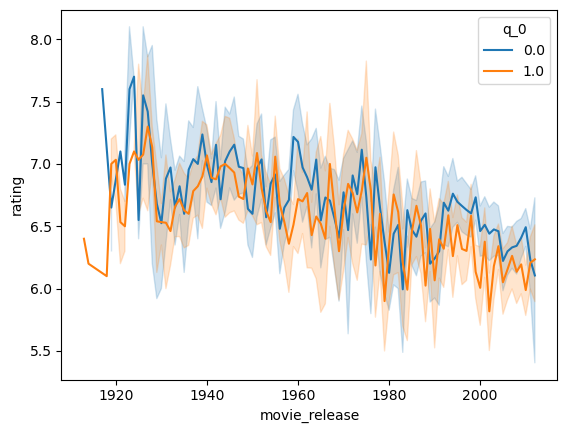

In [24]:
pal = sns.color_palette()
c1 = pal[0]
c2 = pal[1]

sns.lineplot(data = df, x= 'movie_release', y='rating', hue = 'q_0', palette = [c1,c2])
#sns.lineplot(df, x='yearID', y='salary', hue='throws')

In [25]:
s = ''
for i in range(20) : 
    s += '\'q_' + str(i) + '\', '
print(s)

'q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_14', 'q_15', 'q_16', 'q_17', 'q_18', 'q_19', 


In [26]:
df_cleaned2 = df.dropna(subset=questions_list)

#initiate linear regression model

#define predictor and response variables
X, y = df_cleaned2[questions_list], df_cleaned2.rating

#fit regression model
reg = LinearRegression().fit(X, y)

print(reg.coef_)
print(reg.score(X, y))

[-0.23333848 -0.08233946 -0.07099007  0.1161615   0.10679435 -0.00126074
  0.07006016 -0.05048709  0.01622733  0.00790871  0.02579949  0.03663755
  0.02777551 -0.0126412  -0.02365548  0.08450202  0.01223557  0.0417792
  0.08707375  0.10088119]
0.029186145608167458


In [27]:
indices = np.where(np.abs(reg.coef_) > 0.07)
print(indices)

(array([ 0,  1,  2,  3,  4,  6, 15, 18, 19], dtype=int64),)


In [28]:
# This seems to correspond to the most relevant questions 
relevant_questions = ['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_18', 'q_19']

df_cleaned3 = df.dropna(subset=relevant_questions)

X, y = df_cleaned3[relevant_questions], df_cleaned3.rating

#fit regression model
reg = LinearRegression().fit(X, y)

print(reg.coef_)
print(reg.score(X, y))

[-0.22055908 -0.07226556 -0.0618566   0.13394526  0.09998013  0.08869498
  0.10142998]
0.02477116146029712


In [29]:
df_new = df.dropna(subset=questions_list)

X, y = df_new[questions_list].to_numpy(), df_new.rating.to_numpy()

#display(X)
print(X.shape, y.shape)


poly = PolynomialFeatures(interaction_only=True,include_bias = False, degree = 4)
X_new = poly.fit_transform(X)
print(X_new.shape)

reg = LinearRegression()
reg.fit(X_new,y)
print(reg.score(X_new, y))
cv_scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')  # Adjust the number of folds as needed

print(f'Cross-Validation scores: {cv_scores}')

(4275, 20) (4275,)
(4275, 6195)
0.8407998510221123
Cross-Validation scores: [-0.89435114 -0.72943175 -0.7394016  -0.86698155 -0.86571254]


In [30]:
print(X_new.shape, y.shape)
reg = LinearRegression().fit(X_new, y)

#print(reg.coef_)
print(reg.score(X_new, y))

(4275, 6195) (4275,)
0.8407998510221123


# D) Random Forest

In [31]:
cleaned_questions_list = ['q_0', 'q_1', 'q_2', 'q_3', 'q_4', 'q_5', 'q_6', 'q_7', 'q_8', 'q_9', 'q_10', 'q_11', 'q_12', 'q_13', 'q_16', 'q_17', 'q_18', 'q_19']
simple_questions = ['q_0', 'q_1']

In [32]:
# Remove the questions number 15 and 16 as they were observed to be rather unaccurate.
df_cleaned = df.dropna(subset=cleaned_questions_list)
X, y = df_cleaned[cleaned_questions_list], df_cleaned.rating

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=5, random_state=42, max_depth = 15)

# Fit the regressor with x and y data
regressor.fit(X, y)




# Access the OOB Score
#oob_score = regressor.oob_score_
#print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(X)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 0.35998432459562985
R-squared: 0.554341536681747


In [33]:
# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=10, scoring='neg_mean_squared_error')  # Adjust the number of folds as needed

print(f'Cross-Validation scores: {cv_scores}')

Cross-Validation scores: [-1.30377838 -1.03080464 -0.9349083  -1.07971033 -0.96602307 -1.01787351
 -1.04194374 -1.2657573  -1.08505382 -1.13514614]


In [34]:
feature_importances = regressor.feature_importances_
print('Feature Importances:', feature_importances)

Feature Importances: [0.01479923 0.05502889 0.0636521  0.03589646 0.04479014 0.05619191
 0.06616813 0.07423715 0.0569758  0.06748538 0.06061606 0.05031803
 0.04791344 0.07530157 0.06016665 0.04595027 0.07048373 0.05402506]
